In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

    # load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [3]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/기계학습 10주차/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/기계학습 10주차/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [7]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [8]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [9]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Conv1D, Flatten,
    BatchNormalization, Activation,
    Add, GlobalAveragePooling1D,
    LayerNormalization, MultiHeadAttention
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Transformer 블록 정의
def transformer_block(inputs, num_heads=4, ff_dim=128):
    x = LayerNormalization()(inputs)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(x, x)
    x = Add()([x, attn_output])

    x = LayerNormalization()(x)
    ff_output = Dense(ff_dim, activation="relu")(x)
    ff_output = Dense(inputs.shape[-1])(ff_output)

    x = Add()([x, ff_output])
    return x

def build_model(input_shape):
    inputs = Input(shape=input_shape)

    # Transformer Encoder
    x = transformer_block(inputs)
    x = GlobalAveragePooling1D()(x)


    # Fully Connected Layers
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(n_outputs, activation="softmax")(x)  # 3개의 클래스

    model = Model(inputs, outputs)
    return model

model = build_model(input_shape=(n_timesteps,n_features))
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])


In [10]:
history = model.fit(x=X_train, y=y_train_one_hot, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.4142 - loss: 1.3988 - val_accuracy: 0.8387 - val_loss: 0.4826
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7893 - loss: 0.5285 - val_accuracy: 0.9100 - val_loss: 0.2468
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8963 - loss: 0.2999 - val_accuracy: 0.9185 - val_loss: 0.2064
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9144 - loss: 0.2419 - val_accuracy: 0.9151 - val_loss: 0.2048
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9290 - loss: 0.1997 - val_accuracy: 0.9202 - val_loss: 0.1849
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9216 - loss: 0.1954 - val_accuracy: 0.9202 - val_loss: 0.1961
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9236 - loss: 0.1914 - val_accuracy: 0.9389 - val_loss: 0.1381
Epoch 8/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9380 - loss: 0.1624 - val_accuracy: 

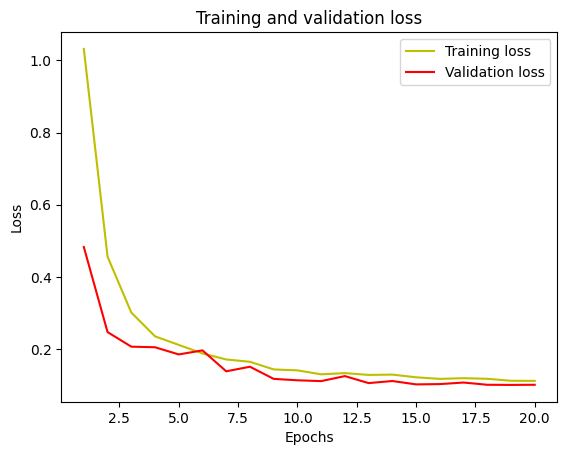

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =history.history['loss']
val_loss =history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

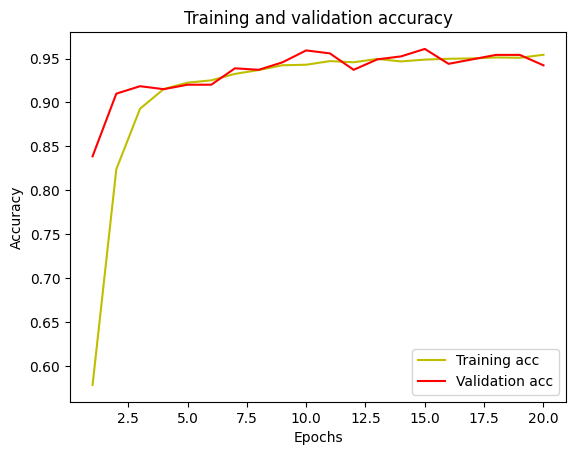

In [12]:
acc =history.history['accuracy']
val_acc =history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
[[456   6  33   0   1   0]
 [ 73 391   7   0   0   0]
 [  7   0 413   0   0   0]
 [  0  19   0 367 100   5]
 [  0   5   0  66 461   0]
 [  0  17   0   0   0 520]]
0.8849677638276213
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       496
           1       0.89      0.83      0.86       471
           2       0.91      0.98      0.95       420
           3       0.85      0.75      0.79       491
           4       0.82      0.87      0.84       532
           5       0.99      0.97      0.98       537

    accuracy                           0.88      2947
   macro avg       0.89      0.89      0.88      2947
weighted avg       0.89      0.88      0.88      2947



<Axes: >

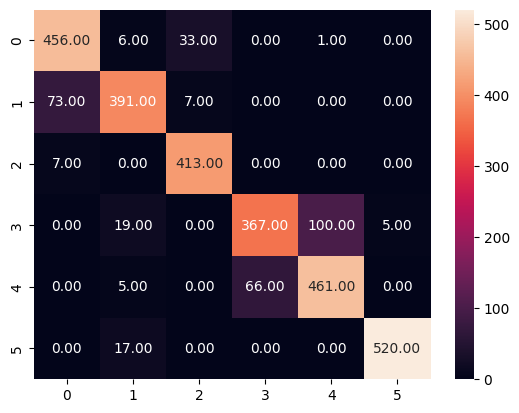

In [13]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=model.predict(testX)
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')